In [ ]:
# imports

!pip install feature-engine
!pip install livelossplot

import warnings
import math
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from pandas import errors
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')


     |████████████████████████████████| 205 kB 627 kB/s            


In [ ]:
file_path = "../input/utkfacedata-annotations/utk_annotations.csv"
column_names = ['filename']


In [ ]:
df = pd.read_csv(file_path, names=column_names)  # reading data


In [ ]:
df.head()  # sneak peak of data


,filename
0,100_0_0_20170112213500903.jpg.chip.jpg
1,100_0_0_20170112215240346.jpg.chip.jpg
2,100_1_0_20170110183726390.jpg.chip.jpg
3,100_1_0_20170112213001988.jpg.chip.jpg
4,100_1_0_20170112213303693.jpg.chip.jpg


In [ ]:
df.info()  # concise summary of data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23709 entries, 0 to 23708
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  23709 non-null  object
dtypes: object(1)
memory usage: 185.4+ KB


In [ ]:
def convert_int(x):
    try:
        return int(x)
    except ValueError:
        return np.nan


In [ ]:
df['filepath'] = df.filename.apply(lambda x: "../input/utkface-new/UTKFace/"+x)


In [ ]:
df['age'] = df.filename.apply(lambda x: convert_int(x.split('_')[0]))


In [ ]:
df['gender'] = df.filename.apply(lambda x: convert_int(x.split('_')[1]))


In [ ]:
df['race'] = df.filename.apply(lambda x: convert_int(x.split('_')[-2]))


In [ ]:
df['date&time'] = pd.to_datetime(df.filename.apply(lambda x: x.split(
    '_')[-1].split('.')[0]), format='yyyymmddHHMMSSFFF', errors='ignore')


In [ ]:
df.dropna(inplace=True)


In [ ]:
df.head()


,filename,filepath,age,gender,race,date&time
0,100_0_0_20170112213500903.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,0.0,0.0,20170112213500903
1,100_0_0_20170112215240346.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,0.0,0.0,20170112215240346
2,100_1_0_20170110183726390.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701101...,100.0,1.0,0.0,20170110183726390
3,100_1_0_20170112213001988.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,1.0,0.0,20170112213001988
4,100_1_0_20170112213303693.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,1.0,0.0,20170112213303693


In [ ]:
# mapping categorical data to numerical
gender_mapper = {0: 'male', 1: 'female'}
race_mapper = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}

df.gender = df.gender.map(gender_mapper)
df.race = df.race.map(race_mapper)

df.head()

,filename,filepath,age,gender,race,date&time
0,100_0_0_20170112213500903.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,male,white,20170112213500903
1,100_0_0_20170112215240346.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,male,white,20170112215240346
2,100_1_0_20170110183726390.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701101...,100.0,female,white,20170110183726390
3,100_1_0_20170112213001988.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,female,white,20170112213001988
4,100_1_0_20170112213303693.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,female,white,20170112213303693


In [ ]:
df.nunique()  # distinct elements in column axis


filename     23708
filepath     23708
age            104
gender           2
race             5
date&time    23482
dtype: int64

In [ ]:
df = df.sample(frac=1)  # randomizing data


In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)


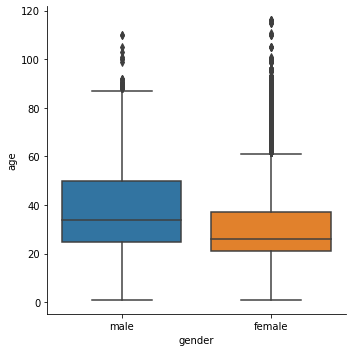

In [ ]:
# box plot for age and gender
sns.catplot(x="gender", y="age", kind="box", data=df)


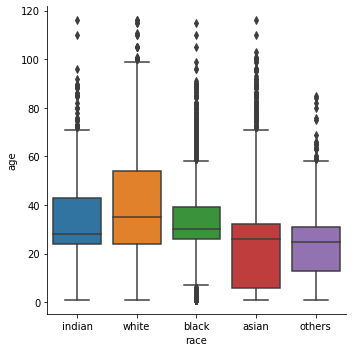

In [ ]:
# box plot for age and race
sns.catplot(x="race", y="age", kind="box", data=df)


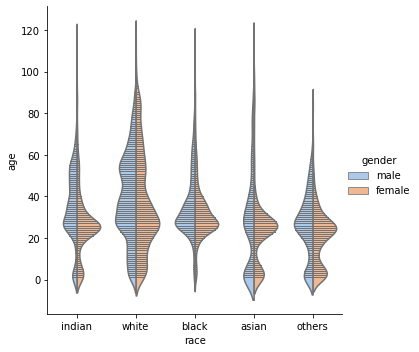

In [ ]:
sns.catplot(x="race", y="age", hue="gender", kind="violin", inner="stick",
            split=True, palette="pastel", data=df)  # plot visualizing features


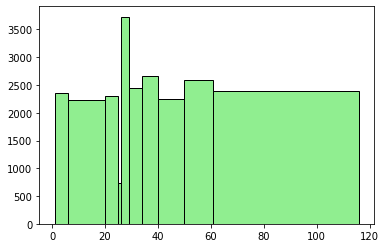

In [ ]:
# equal frequency binning
def equalFrequencyDiscretiser(data, nbin):
    return np.interp(np.linspace(0, len(data), nbin + 1), np.arange(len(data)), np.sort(data))


# visualizing binning
n, bins, patches = plt.hist(df.age, equalFrequencyDiscretiser(
    df.age, 10), color='lightgreen', edgecolor='black')
plt.show()


Discretization is the process of converting continuous variables, models, or functions to discrete form. We accomplish this by generating a series of contiguous intervals (or bins) that span the desired variable/model/function. Mathematical problems with continuous data have an infinite number of degrees of freedom (DoF). Because our calculations cannot go on indefinitely, such a problem would necessitate having limited degrees of freedom (DoF). Because of their infinite degrees of freedom, continuous features have a lower chance of correlating with the target variable and may have a complex non-linear relationship. As a result, interpreting such a function may be more difficult. Groups corresponding to the target can be interpreted after a variable has been discretized. The most commonly used discretization approaches are equal-width and equal-frequency, but for our data considering age, equal-frequency is preferable because it improves the value spread, can handle outliers, and can be combined with categorical encoding.

In [ ]:
TRAIN_TEST_SPLIT = 0.7 # test train split


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224 # declaring image shape


In [ ]:
# data generator class
class UTKFaceDataGenerator():
    # constructor
    def __init__(self, df):
        self.df = df

    # spliting data into test, train and validation indices
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        self.df['gender_id'] = self.df['gender'].map(
            dict((v, k) for k, v in gender_mapper.items()))
        self.df['race_id'] = self.df['race'].map(
            dict((v, k) for k, v in race_mapper.items()))
        self.max_age = self.df['age'].max()
        return train_idx, valid_idx, test_idx

    # preprocessing image
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT))
        im = np.array(im) / 255.0
        return im

    # creating images based on split and preprocess images
    def generate_images(self, image_idx, is_training, batch_size=16):
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['filepath']
                im = self.preprocess_image(file)
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(race_mapper)))
                genders.append(to_categorical(gender, len(gender_mapper)))
                images.append(im)
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
            if not is_training:
                break


In [ ]:
# creating  data generator object and spliting indicies
data_generator = UTKFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()


In [ ]:
# class for building classification model for predicting age, gender and race
class UTKFaceOutputModel():
    # vgg16 cnn architecture as feature extractor
    def feature_extractor(self, inputs):
        l1 = inputs
        l2 = Conv2D(64, (3,3), padding='same', activation='relu')(l1)
        l3 = Conv2D(64, (3,3), padding='same', activation='relu')(l2)
        l4 = MaxPooling2D((2,2), strides=(2,2))(l3)
        l5 = Conv2D(128, (3,3), padding='same', activation='relu')(l4)
        l6 = Conv2D(128, (3,3), padding='same', activation='relu')(l5)
        l7 = MaxPooling2D((2,2), strides=(2,2))(l6)
        l8 = Conv2D(256, (3,3), padding='same', activation='relu')(l7)
        l9 = Conv2D(256, (3,3), padding='same', activation='relu')(l8)
        l10 = Conv2D(256, (3,3), padding='same', activation='relu')(l9)
        l11 = MaxPooling2D((2,2), strides=(2,2))(l10)
        l12 = Conv2D(512, (3,3), padding='same', activation='relu')(l11)
        l13 = Conv2D(512, (3,3), padding='same', activation='relu')(l12)
        l15 = Conv2D(512, (3,3), padding='same', activation='relu')(l13)
        l16 = MaxPooling2D((2,2), strides=(2,2))(l15)
        l17 = Conv2D(512, (3,3), padding='same', activation='relu')(l16)
        l18 = Conv2D(512, (3,3), padding='same', activation='relu')(l17)
        l19 = Conv2D(512, (3,3), padding='same', activation='relu')(l18)
        l20 = MaxPooling2D((2,2), strides=(2,2))(l19)
        return l20

    # final dense layers for predicting age
    def age_branch(self, inputs):
        l1 = Flatten()(inputs)
        l2 = Dense(4096, activation='relu')(l1)
        l3 = Dense(4096, activation='relu')(l2)
        l4 = Dense(1, activation='linear', name="age_output")(l3)
        return l4

    # final dense layers for predicting gender
    def gender_branch(self, inputs, num_genders=2):
        l1 = Flatten()(inputs)
        l2 = Dense(4096, activation='relu')(l1)
        l3 = Dense(4096, activation='relu')(l2)
        l4 = Dense(num_genders, activation='softmax', name="gender_output")(l3)
        return l4

    # final dense layers for predicting race
    def race_branch(self, inputs, num_races):
        l1 = Flatten()(inputs)
        l2 = Dense(4096, activation='relu')(l1)
        l3 = Dense(4096, activation='relu')(l2)
        l4 = Dense(num_races, activation='softmax', name="race_output")(l3)
        return l4

    # combining all the layers and returning final model
    def full_model(self, width, height, num_races):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        feature_extractor = self.feature_extractor(inputs)
        age_branch = self.age_branch(feature_extractor)
        gender_branch = self.gender_branch(feature_extractor)
        race_branch = self.race_branch(feature_extractor, num_races)
        model = Model(inputs=inputs,
                      outputs=[age_branch, race_branch, gender_branch],
                      name="utk_face_net")
        return model


In [ ]:
# extending base class for creating new model using transfer learning
class TL_UTKFaceOutputModel(UTKFaceOutputModel):
    # using base vgg16 as feature extractor
    def full_model(self, width, height, num_races):
        input_shape = (height, width, 3)
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
        base_model.trainable = False # Not trainable weights
        feature_extractor = base_model.output
        age_branch = self.age_branch(feature_extractor)
        gender_branch = self.gender_branch(feature_extractor)
        race_branch = self.race_branch(feature_extractor, num_races)
        model = Model(inputs=base_model.inputs,
                      outputs=[age_branch, race_branch, gender_branch],
                      name="tl_utk_face_net")
        return model


In [ ]:
# creating model object and displaying summary 
tl_model = TL_UTKFaceOutputModel().full_model(
    IMG_WIDTH, IMG_HEIGHT, num_races=len(race_mapper))
tl_model.summary()

2022-03-08 14:30:58.297855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 14:30:58.425976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 14:30:58.427080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 14:30:58.428911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 0s 0us/step
Model: "tl_utk_face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________

In [ ]:
plot_model(tl_model, to_file='tl_model.png') # visualizing model

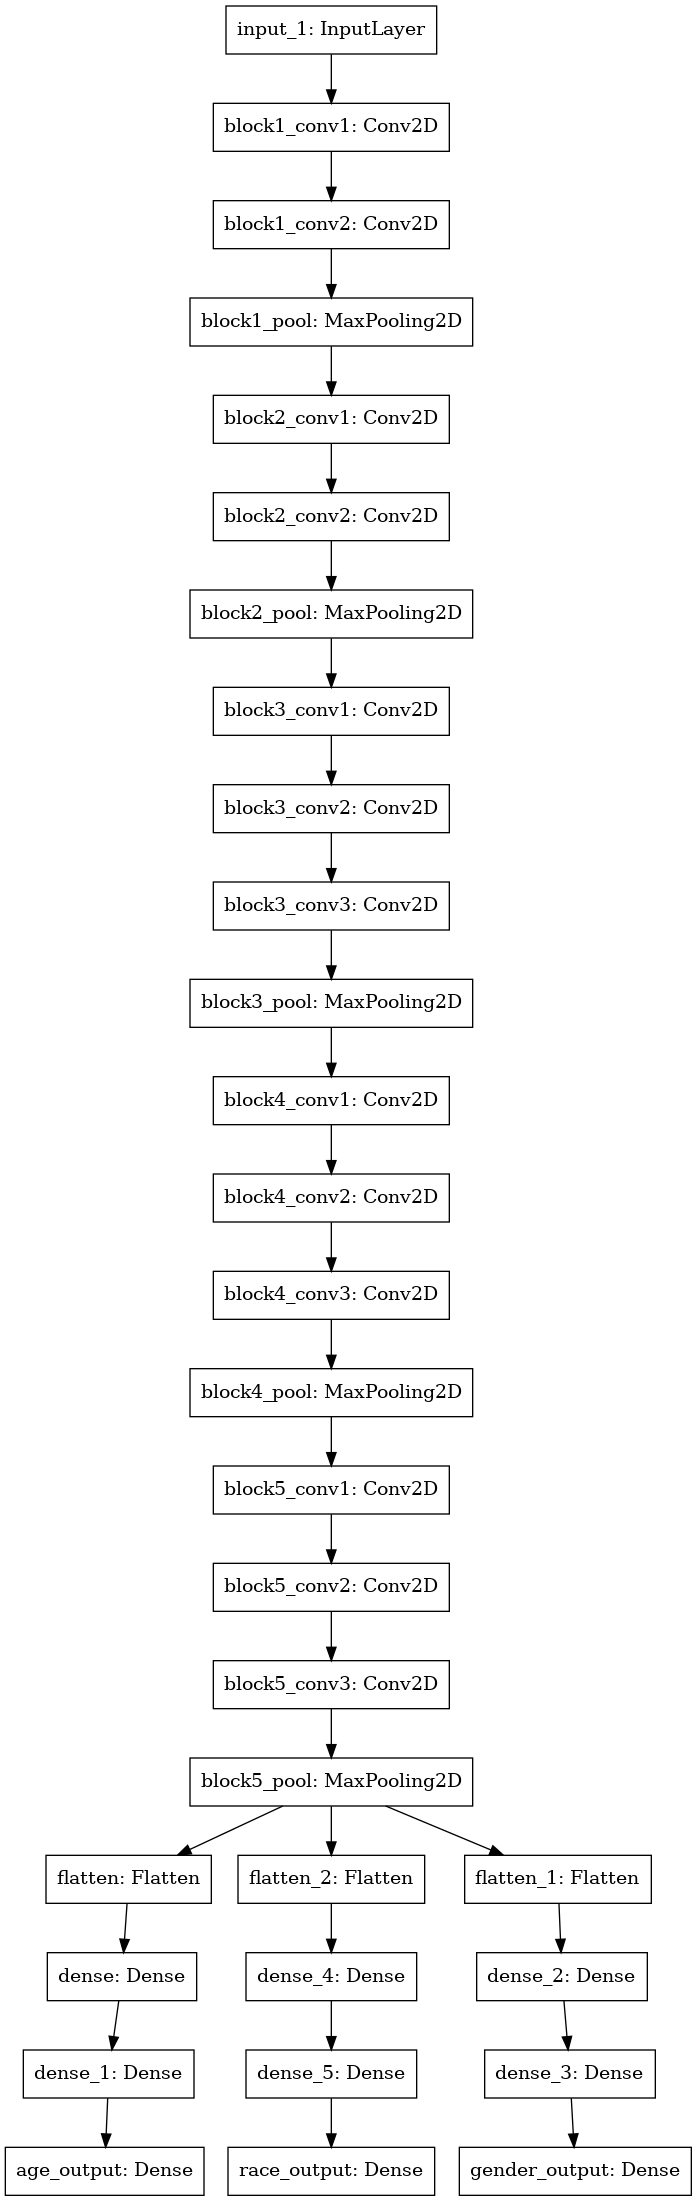

In [ ]:
# setting hyper parameters
lr = 1e-4
epochs = 3


In [ ]:
opt = Adam(lr=lr, decay=lr / epochs) # optimizer
# compiling model
tl_model.compile(optimizer=opt,
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},

              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})


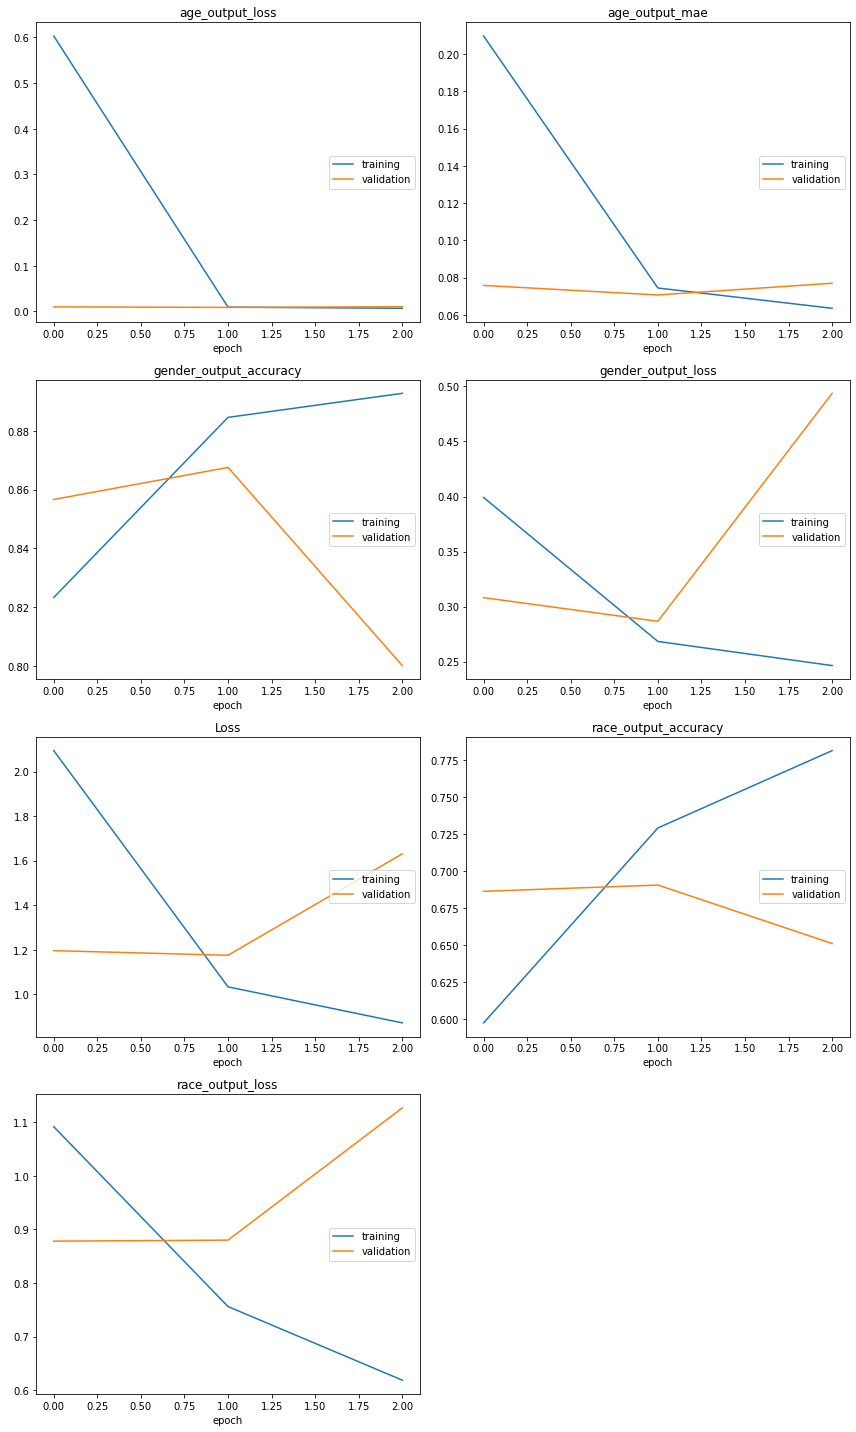

age_output_loss
	training         	 (min:    0.007, max:    0.603, cur:    0.007)
	validation       	 (min:    0.009, max:    0.010, cur:    0.010)
age_output_mae
	training         	 (min:    0.064, max:    0.210, cur:    0.064)
	validation       	 (min:    0.071, max:    0.077, cur:    0.077)
gender_output_accuracy
	training         	 (min:    0.823, max:    0.893, cur:    0.893)
	validation       	 (min:    0.800, max:    0.868, cur:    0.800)
gender_output_loss
	training         	 (min:    0.246, max:    0.399, cur:    0.246)
	validation       	 (min:    0.287, max:    0.494, cur:    0.494)
Loss
	training         	 (min:    0.872, max:    2.094, cur:    0.872)
	validation       	 (min:    1.175, max:    1.631, cur:    1.631)
race_output_accuracy
	training         	 (min:    0.597, max:    0.781, cur:    0.781)
	validation       	 (min:    0.651, max:    0.690, cur:    0.651)
race_output_loss
	training         	 (min:    0.619, max:    1.092, cur:    0.619)
	validation       	 (min: 

In [ ]:
# setting batch size
train_batch_size = 32
val_batch_size = 32

# creating train and validation generators
train_generator = data_generator.generate_images(
    train_idx, is_training=True, batch_size=train_batch_size)
val_generator = data_generator.generate_images(
    valid_idx, is_training=True, batch_size=val_batch_size)
checkpoint = ModelCheckpoint("model_params.h5", monitor='val_loss') # creating model checkpoint
callbacks = [PlotLossesKerasTF(), checkpoint] # callbacks plotting graphs and checkpoints

# fitting model
history = tl_model.fit(train_generator,
                    steps_per_epoch=len(train_idx)//train_batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=len(valid_idx)//val_batch_size)


In [ ]:
tl_model = keras.models.load_model("./model_params.h5") # loading model


In [ ]:
# creating test generator and predicting features
test_batch_size = 128
test_generator = data_generator.generate_images(
    test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = tl_model.predict(test_generator,
                                                 steps=len(test_idx)//test_batch_size)


2022-03-08 14:40:44.579941: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [ ]:
test_generator = data_generator.generate_images(
    test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])

age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age


In [ ]:
cr_gender = classification_report(
    gender_true, gender_pred, target_names=gender_mapper.values())
cr_gender


'              precision    recall  f1-score   support\n\n        male       0.73      0.98      0.84      3695\n      female       0.97      0.61      0.75      3345\n\n    accuracy                           0.80      7040\n   macro avg       0.85      0.79      0.79      7040\nweighted avg       0.84      0.80      0.79      7040\n'

<AxesSubplot:>

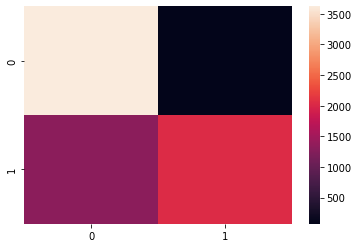

In [ ]:
cm = confusion_matrix(gender_true, gender_pred)
sns.heatmap(cm)


In [ ]:
cr_race = classification_report(
    race_true, race_pred, target_names=race_mapper.values())
cr_race


'              precision    recall  f1-score   support\n\n       white       0.71      0.87      0.78      3013\n       black       0.96      0.31      0.47      1330\n       asian       0.51      0.85      0.64      1062\n      indian       0.59      0.54      0.56      1139\n      others       0.27      0.05      0.08       496\n\n    accuracy                           0.65      7040\n   macro avg       0.61      0.52      0.51      7040\nweighted avg       0.68      0.65      0.62      7040\n'

<AxesSubplot:>

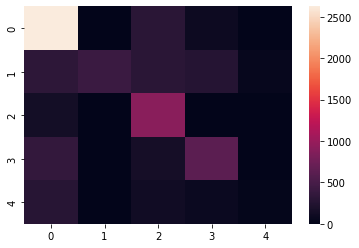

In [ ]:
cm = confusion_matrix(race_true, race_pred)
sns.heatmap(cm)


In [ ]:
print('R2 score for age: ', r2_score(age_true, age_pred))


R2 score for age:  0.6403106234110622
